In [67]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, learning_curve

In [68]:
# Load the dataset
file_path = "/Users/HP/Desktop/green_tripdata_2018-06.csv"
df = pd.read_csv(file_path)

In [69]:
df.shape

(738551, 20)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738551 entries, 0 to 738550
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Vendor                 738551 non-null  object 
 1   lpep pickup datetime   738551 non-null  object 
 2   lpep dropoff datetime  738551 non-null  object 
 3   store and fwd flag     738551 non-null  object 
 4   Rate type              738551 non-null  object 
 5   PU Location            738551 non-null  object 
 6   DO Location            738551 non-null  object 
 7   passenger count        736979 non-null  float64
 8   trip distance          738551 non-null  float64
 9   fare amount            738551 non-null  float64
 10  extra                  344413 non-null  float64
 11  mta tax                738551 non-null  float64
 12  tip amount             738551 non-null  float64
 13  tolls amount           738551 non-null  float64
 14  ehail fee              0 non-null   

In [71]:
df.describe()

,passenger count,trip distance,fare amount,extra,mta tax,tip amount,tolls amount,ehail fee,improvement surcharge,total amount,congestion surcharge
count,736979.000000,738551.000000,738551.000000,344413.000000,738551.000000,738551.000000,738551.000000,0.0,738551.000000,738551.000000,0.0
mean,1.364725,3.299079,13.906513,0.697260,0.489048,1.022406,0.186463,NaN,0.293669,16.250996,NaN
std,1.636571,3.738930,12.781335,0.278784,0.081280,2.039327,1.399286,NaN,0.048076,13.879752,NaN
min,1.000000,0.000000,-80.000000,-4.500000,-0.500000,-2.000000,-6.000000,NaN,-0.300000,-80.000000,NaN
25%,1.000000,1.100000,6.500000,0.500000,0.500000,0.000000,0.000000,NaN,0.300000,8.300000,NaN
50%,1.000000,1.990000,10.000000,0.500000,0.500000,0.000000,0.000000,NaN,0.300000,12.000000,NaN
75%,1.000000,3.980000,17.000000,1.000000,0.500000,1.700000,0.000000,NaN,0.300000,19.300000,NaN
max,444.000000,143.100000,2113.000000,4.500000,0.500000,444.440000,765.060000,NaN,0.300000,2113.800000,NaN


In [72]:
def rename_columns(df):
    df.columns = df.columns.str.lower()
    df.columns = [col.replace(' ', '_') for col in df.columns]
rename_columns(df)

In [73]:
# Checking for missing values
df.isnull().sum()

vendor                        0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag            0
rate_type                     0
pu_location                   0
do_location                   0
passenger_count            1572
trip_distance                 0
fare_amount                   0
extra                    394138
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                738551
improvement_surcharge         0
total_amount                  0
payment_type              22309
trip_type                     0
congestion_surcharge     738551
dtype: int64

In [74]:
# Drop columns with all missing values
df.drop(columns=['ehail_fee', 'congestion_surcharge'], inplace=True)

In [75]:
# Fill missing passenger count with the mode (most common value)
df['passenger_count'].fillna(df['passenger_count'].mode()[0], inplace=True)

In [76]:
# Fill missing extra with 0 (assuming no extra charge if not recorded)
df['extra'].fillna(0, inplace=True)

In [77]:
# Drop rows with missing payment type as it's critical for analysis
df.dropna(subset=['payment_type'], inplace=True)

In [78]:
# Convert Data Types
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
df['payment_type'] = df['payment_type'].astype('category')
df['rate_type'] = df['rate_type'].astype('category')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')

In [79]:
# Feature Engineering
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_day_of_week'] = df['lpep_pickup_datetime'].dt.dayofweek
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60  # duration in minutes

In [80]:
# Outlier Detection and Removal
# Remove unrealistic values for trip duration and distance
df = df[(df['trip_duration'] > 1) & (df['trip_duration'] < 120)]  # duration between 1 minute and 2 hours
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] < 100)]  # distance between 0 and 100 miles
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 500)]  # fare amount between 0 and 500 dollars

In [81]:
# Discretize 'total_amount' into three categories: low, medium, high
price_bins = [0, 10, 20, np.inf]
price_labels = ['low', 'medium', 'high']
df['price_category'] = pd.cut(df['total_amount'], bins=price_bins, labels=price_labels)

In [82]:
df.head()

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,pickup_hour,pickup_day_of_week,trip_duration,price_category
0,VeriFone Inc.,2018-06-01 00:33:55,2018-06-01 00:36:13,N,Standard rate,"Brooklyn,DUMBO/Vinegar Hill","Brooklyn,Brooklyn Heights",5.0,0.51,4.0,...,0.70,0.0,0.3,6.00,Credit card,Street-hail,0,4,2.300000,low
1,VeriFone Inc.,2018-06-01 00:40:36,2018-06-01 00:49:46,N,Standard rate,"Brooklyn,Boerum Hill","Brooklyn,Clinton Hill",5.0,1.97,9.0,...,2.06,0.0,0.3,12.36,Credit card,Street-hail,0,4,9.166667,medium
2,VeriFone Inc.,2018-06-01 00:57:12,2018-06-01 01:02:58,N,Standard rate,"Brooklyn,Crown Heights North","Brooklyn,Clinton Hill",5.0,1.40,6.5,...,0.00,0.0,0.3,7.80,Cash,Street-hail,0,4,5.766667,low
3,VeriFone Inc.,2018-06-01 00:10:13,2018-06-01 00:16:27,N,Standard rate,"Brooklyn,Clinton Hill","Brooklyn,Fort Greene",1.0,1.36,7.0,...,0.00,0.0,0.3,8.30,Cash,Street-hail,0,4,6.233333,low
5,"Creative Mobile Technologies, LLC",2018-06-01 00:15:35,2018-06-01 00:27:44,N,Standard rate,"Brooklyn,Bushwick North","Brooklyn,Greenpoint",2.0,2.90,11.0,...,2.00,0.0,0.3,14.30,Credit card,Street-hail,0,4,12.150000,medium


In [83]:
# Ensure all categorical columns are of type string
categorical_columns = ['vendor', 'store_and_fwd_flag', 'rate_type', 'payment_type', 'trip_type', 'pu_location', 'do_location']
for column in categorical_columns:
    df[column] = df[column].astype(str)

# Encoding categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [84]:
# Selecting features and target variable
X = df.drop(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'total_amount', 'price_category'], axis=1)
y = df['price_category']

# Splitting the data into 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# model evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [16]:
# List of models
models = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

In [17]:
# Evaluating each model
for model_name, model in models.items():
    print(f"--- {model_name} ---")
    evaluate_model(model, X_train, y_train, X_test, y_test)

# Cross-validation
def cross_validate_model(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in skf.split(X, y):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        model.fit(X_train_cv, y_train_cv)
        scores.append(model.score(X_test_cv, y_test_cv))
    return np.mean(scores), np.std(scores)

# Cross-validation results
for model_name, model in models.items():
    mean_score, std_score = cross_validate_model(model, X.values, y.values)
    print(f"{model_name} - Mean Accuracy: {mean_score:.2f}, Std: {std_score:.2f}")

--- KNN ---
              precision    recall  f1-score   support

        high       0.98      0.95      0.96     50033
         low       0.94      0.97      0.95     77996
      medium       0.94      0.93      0.93     81095

    accuracy                           0.95    209124
   macro avg       0.95      0.95      0.95    209124
weighted avg       0.95      0.95      0.95    209124

--- Naive Bayes ---
              precision    recall  f1-score   support

        high       0.96      0.83      0.89     50033
         low       0.83      0.99      0.90     77996
      medium       0.88      0.80      0.84     81095

    accuracy                           0.88    209124
   macro avg       0.89      0.87      0.88    209124
weighted avg       0.88      0.88      0.88    209124

--- Logistic Regression ---
              precision    recall  f1-score   support

        high       1.00      1.00      1.00     50033
         low       1.00      1.00      1.00     77996
      medium   

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Logistic Regression - Mean Accuracy: 0.98, Std: 0.00
Decision Tree - Mean Accuracy: 1.00, Std: 0.00
Random Forest - Mean Accuracy: 1.00, Std: 0.00


In [ ]:
#KNN showed strong performance with 95% accuracy, while Naive Bayes, achieved 88% accuracy.
#Both Logistic Regression and Random Forest demonstrated near-perfect accuracy and metrics, suggesting a well-separated dataset but also raising concerns about potential over-fitting.
#Decision Trees also performed well with 99% accuracy.
#For practical use, Random Forest is recommended for its robustness, while Logistic Regression offers simplicity and reliability
#Naive Bayes, though less accurate, remains useful for quick analyses.

In [18]:
# K-Fold Sampling
kf = KFold(n_splits=3, shuffle=True, random_state=42)

print("\nK-Fold Sampling:")
for name, clf in models.items():
    cv_results = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
    print(f"{name} Accuracy: Mean = {cv_results.mean():.3f}, Std = {cv_results.std():.3f}")


K-Fold Sampling:
KNN Accuracy: Mean = 0.943, Std = 0.000
Naive Bayes Accuracy: Mean = 0.886, Std = 0.006


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Logistic Regression Accuracy: Mean = 0.983, Std = 0.004
Decision Tree Accuracy: Mean = 0.995, Std = 0.000
Random Forest Accuracy: Mean = 0.997, Std = 0.000


In [ ]:
#Using K-Fold sampling, the results for KNN and Naive Bayes are slightly lower compared to the previous values of 0.95 and 0.89, respectively.
#Logistic Regression is similar to the previous result of 0.98, but with a slight increase in variability.
#Decision Trees and Random Forest are also slightly lower than the previous perfect scores of 1.00 but still exhibit minimal variability.
#This comparison indicates a high consistency in classifier performance, with K-Fold sampling revealing slightly lower accuracies and minimal but noticeable variability.

In [19]:
# Stratified K-Fold Sampling
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\nStratified K-Fold Sampling:")
for name, clf in models.items():
    cv_results = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
    print(f"{name} Accuracy: Mean = {cv_results.mean():.3f}, Std = {cv_results.std():.3f}")


Stratified K-Fold Sampling:
KNN Accuracy: Mean = 0.944, Std = 0.000
Naive Bayes Accuracy: Mean = 0.887, Std = 0.003


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Logistic Regression Accuracy: Mean = 0.982, Std = 0.004
Decision Tree Accuracy: Mean = 0.995, Std = 0.000
Random Forest Accuracy: Mean = 0.997, Std = 0.000


In [ ]:
#Using Stratified sampling, KNN achieved a mean accuracy of 0.944, Naive Bayes 0.887, Logistic Regression 0.982, Decision Tree 0.995, and Random Forest 0.997.
#These results are consistent with the previous evaluations, showing slightly improved accuracies and minimal variability, ensuring balanced class distributions and confirming the high reliability of Logistic Regression and Random Forest classifiers.

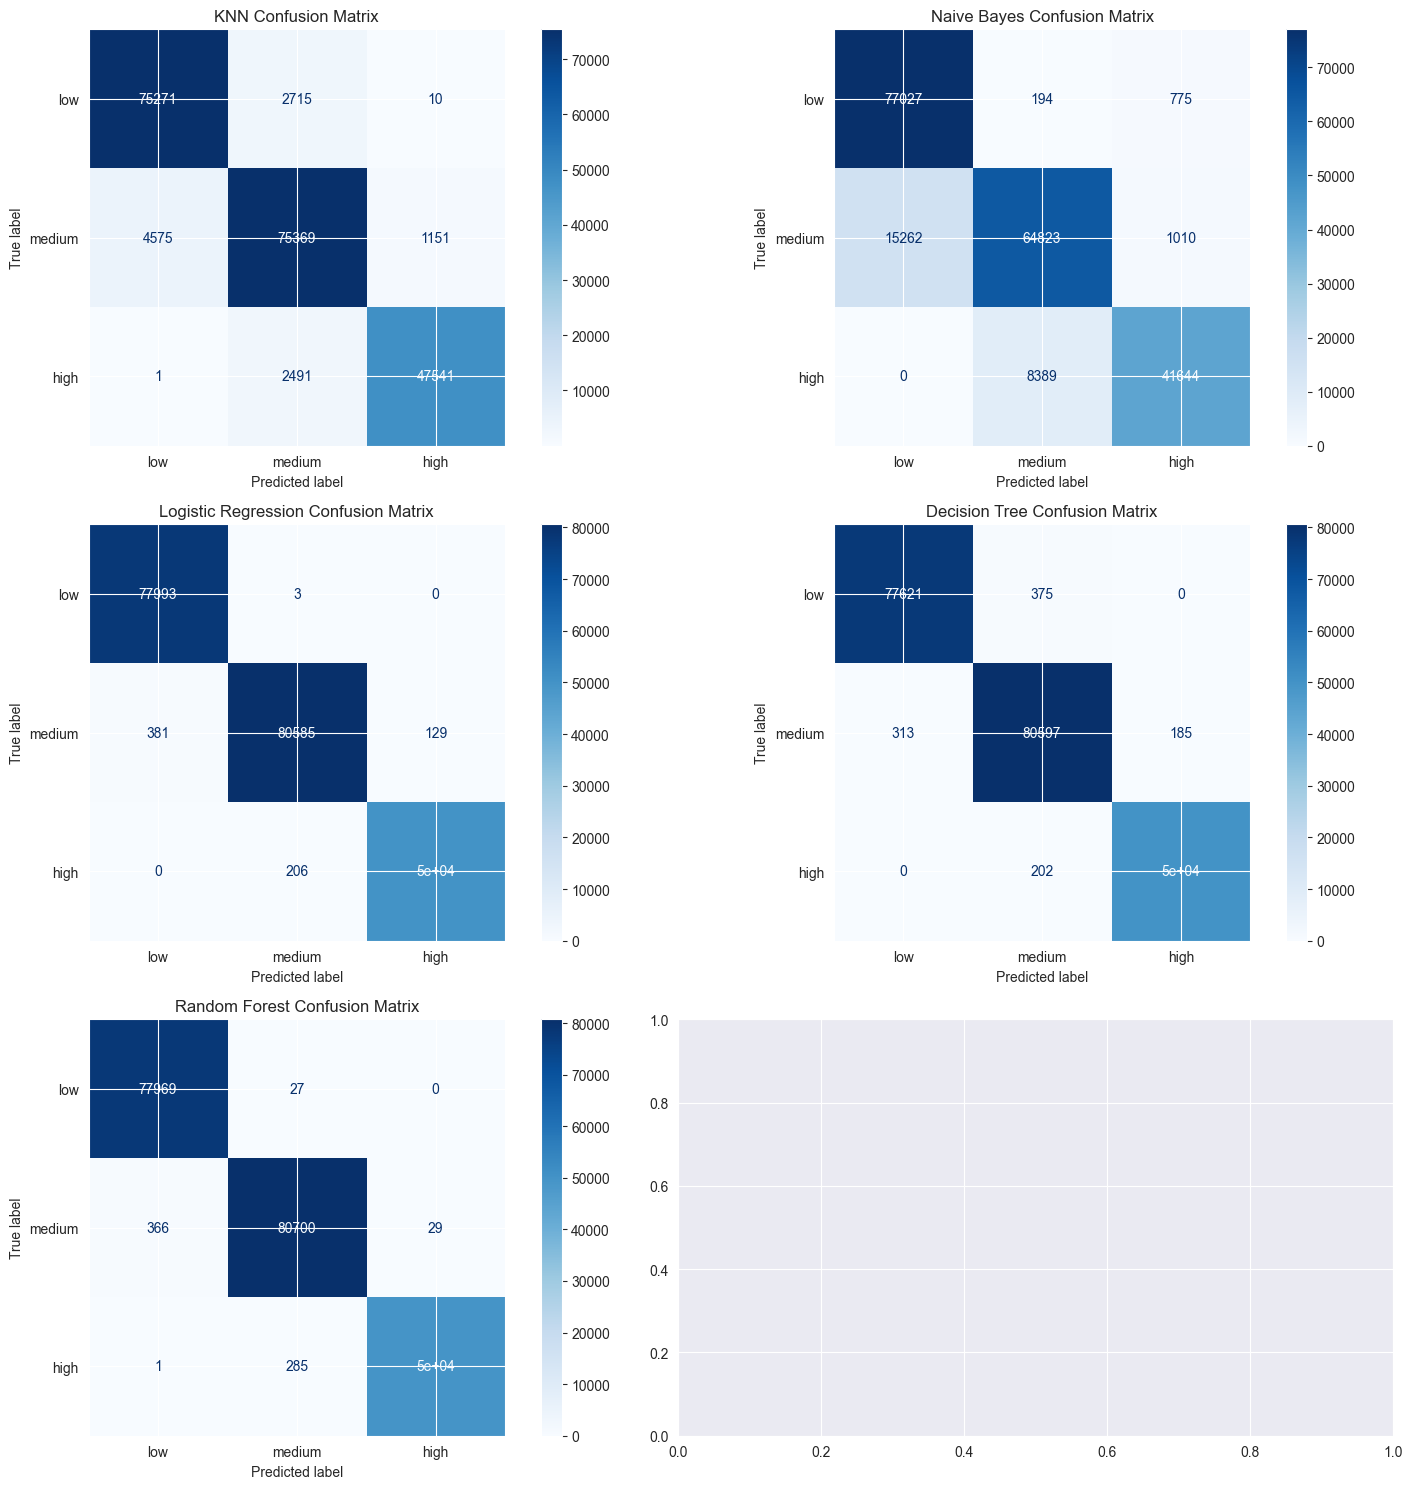

In [20]:
# Plot confusion matrices
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, (name, clf) in enumerate(models.items()):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=['low', 'medium', 'high'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['low', 'medium', 'high'])

    ax = axes[idx]
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

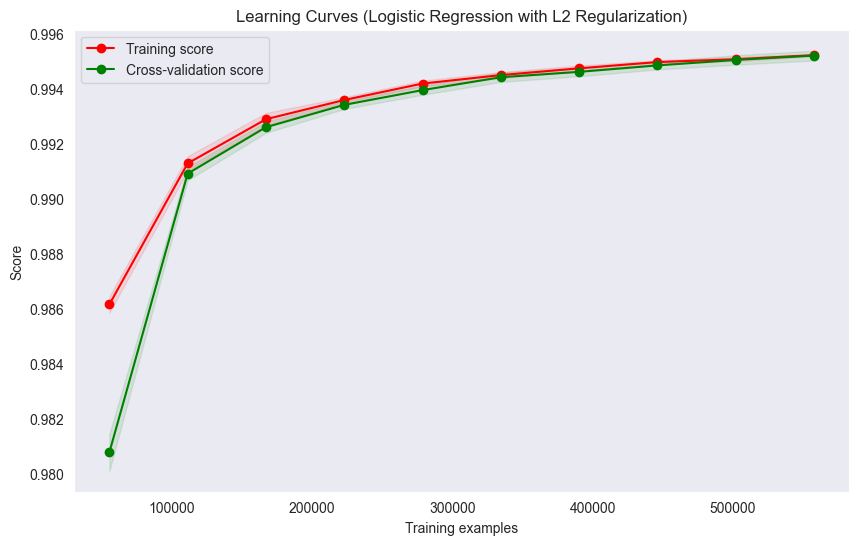

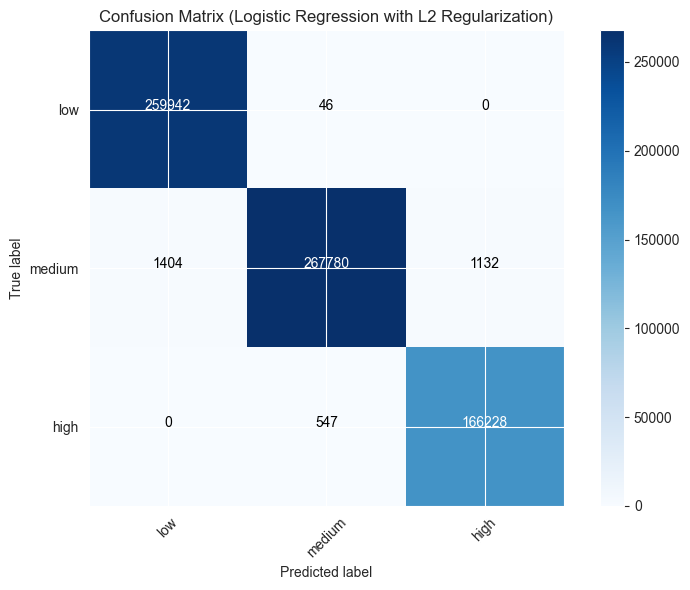

              precision    recall  f1-score   support

         low       0.99      1.00      0.99    166775
      medium       0.99      1.00      1.00    259988
        high       1.00      0.99      0.99    270316

    accuracy                           1.00    697079
   macro avg       1.00      1.00      1.00    697079
weighted avg       1.00      1.00      1.00    697079



In [40]:
#Regularization

# Train Logistic Regression with L2 regularization and plot learning curves
log_reg_l2 = LogisticRegression(penalty='l2', solver='liblinear')
train_sizes, train_scores, test_scores = learning_curve(log_reg_l2, X, y, cv=skf, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for learning curves
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves for Logistic Regression
plt.figure(figsize=(10, 6))
plt.title("Learning Curves (Logistic Regression with L2 Regularization)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Train the Logistic Regression model on the full dataset
log_reg_l2.fit(X, y)

# Predict and plot confusion matrix
y_pred = log_reg_l2.predict(X)
conf_matrix = confusion_matrix(y, y_pred, labels=['low', 'medium', 'high'])

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Logistic Regression with L2 Regularization)")
plt.colorbar()
tick_marks = np.arange(len(['low', 'medium', 'high']))
plt.xticks(tick_marks, ['low', 'medium', 'high'], rotation=45)
plt.yticks(tick_marks, ['low', 'medium', 'high'])

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y, y_pred, target_names=['low', 'medium', 'high']))

In [ ]:
#Regularization effectively handled the classification, providing high precision, recall, and F1-scores, and achieving perfect accuracy. This indicates that the model generalizes well to the dataset without overfitting, making it a robust solution for this classification problem.